# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [3]:
!pip uninstall numpy -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [4]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


**Note:** A pop-up will appear prompting you to restart the session. Please click on it, and then begin running the notebook from the cell below — not from the beginning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:

df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv')

In [5]:
df.columns =['user_id', 'prod_id', 'rating', 'timestamp']
df=df.drop('timestamp', axis=1)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


In [11]:
df=df_final

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
df.shape

(65290, 3)

**We have reduced the amount of data from ~7.2 million entries to roughly 65 thousand entries. This shows that the majority of the data in the original csv file was underrated or the user wasn't an avid rater. Now we have a consolidated dataframe that will be better at predicting recommending projects to users. We also, only have three columns (user_id, rating, and prod_id) which will be usefull to incorporate into our model.**

### **Data types**

In [14]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here: user_id and prod_id are object types which makes sense because they are a string of "random" number and letters. They should remain strings because I won't be performing mathmatical operations on them because they are ids. Rating is a numerical value, it could be an integer since there are no decimal ratings.**

### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
df.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**There are no missing values which means that I don't have to handle them when I perform data preprocessing.**

### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
df['rating'].describe().T

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here: The range of the rating is from 1-5 which mimics common rating systems. The median is a 5 which shows that a majority of people were satisfied with their products. The mean value corroborates this finding as the average rating value is a 4.29 which is relatively high for product ratings.**

### **Checking the rating distribution**

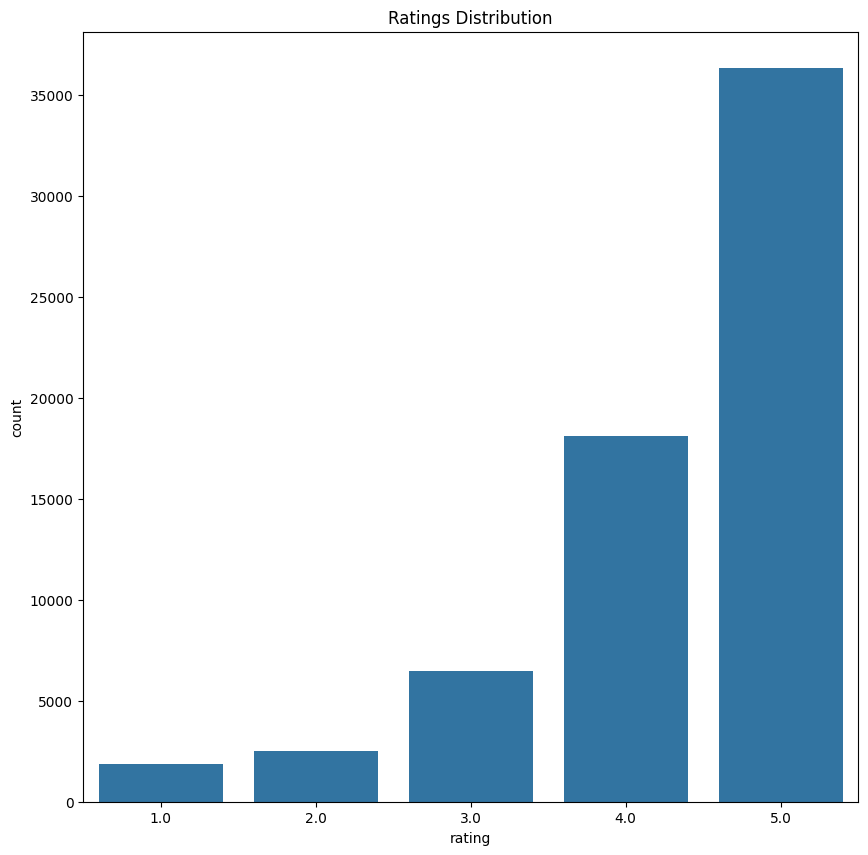

In [17]:
# Create the bar plot and provide observations
plt.figure(figsize=(10,10))
sns.countplot(data=df, x='rating')
plt.title('Ratings Distribution')
plt.show()

**Write your observations here: The graph is skewed to the left with the majority of the values being in the 4-5 range. This shows that users were generally satisfied with their products (YAY!).This corroborates the findings in the summary table for ratings as most of the reviews were in the 4-5 range.**

### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data
total_users = df.shape[0]
print(f'Total rows: {total_users}')

print(f'Number of distinct user_ids: {df['user_id'].nunique()}')
print(f'Number of distinct product_ids: {df['prod_id'].nunique()}')

print(f"Avg Num of ratings per user: {total_users/1540}")
print(f"Avg Num of ratings per product: {total_users/5689}")


Total rows: 65290
Number of distinct user_ids: 1540
Number of distinct product_ids: 5689
Avg Num of ratings per user: 42.396103896103895
Avg Num of ratings per product: 11.476533661451924


**Write your observations here:There are 65,290 rows in the dataset. Of those 65,290 rows, there are 1590 distinct users and 5689 distinct product ids. On average every user in our modified dataframe has given ~42 ratings and each product has recieved ~11 ratings**

### **Users with the most number of ratings**

In [19]:
# Top 10 users based on the number of ratings
user_count=df.groupby('user_id').count()

user_count.sort_values('prod_id', ascending=False)[:10]



,prod_id,rating
user_id,,
ADLVFFE4VBT8,295,295
A3OXHLG6DIBRW8,230,230
A1ODOGXEYECQQ8,217,217
A36K2N527TXXJN,212,212
A25C2M3QF9G7OQ,203,203
A680RUE1FDO8B,196,196
A22CW0ZHY3NJH8,193,193
A1UQBFCERIP7VJ,193,193
AWPODHOB4GFWL,184,184


**Write your observations here: The top 10 users that have given the most ratings have written over 179 ratings. These individuals are likely outliers due to the sheer amount of reviews that have provided to the site. The user with the most ratings have given almost 300 individual ratings.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [20]:
# Calculate the average rating for each product
averaged_product_rating=df.groupby('prod_id').mean('rating')

# Calculate the count of ratings for each product
prod_rating_count=df.groupby('prod_id').count()
prod_rating_count=prod_rating_count['rating']
# Create a dataframe with calculated average and count of ratings
final_rating=averaged_product_rating.merge(prod_rating_count,
                              on='prod_id',
                              how='left')
final_rating.columns=[ 'avg_rating', 'rating_count']

# Sort the dataframe by average of ratings in the descending order
final_rating=final_rating.sort_values('avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.000000,5
B003DZJQQI,5.000000,14
B005FDXF2C,5.000000,7
B00I6CVPVC,5.000000,7
B00B9KOCYA,5.000000,8
...,...,...
B003O2RVGM,1.833333,12
B000ND75C0,1.833333,6
B007C0Y7RI,1.625000,8


In [21]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(df,n, min_interactions):

  # Finding products with minimum number of interactions
  min_interaction_products = df[df['rating_count']>min_interactions]

  # Sorting values with respect to average rating
  sorted_products=min_interaction_products.sort_values('avg_rating', ascending=False)

  return sorted_products.head(n)


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
top_n_products(final_rating, 5, 50)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
top_n_products(final_rating, 5,100)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106
B004CLYEDC,4.669492,118


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [29]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

from collections import defaultdict

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [84]:

def precision_recall_at_k(model, k = 10, threshold = 4.0):
    """Returns precision and recall at k metrics for each user."""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(test)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant. When n_rec_k is 0,
        # Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended. When n_rel is 0,
        # Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2*precision * recall) / (precision + recall), 3))

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [85]:
# Instantiating Reader scale with expected rating scale

reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets

trainset, test = train_test_split(data, test_size=0.2, random_state=1)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [86]:
# Declaring the similarity options
sim_options= {
    'name':'cosine',
    'user_based':True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=42)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0260
Precision:  0.851
Recall:  0.801
F_1 score:  0.825


**Write your observations here: I changed the threshold to 4.0 because the 3.5 numbers weren't making sense. The model reasonably predicted the products. THe RMSE being around 1 means that on average the ratings are 1 star off from the real value. The precision indicates that around 85% of the items were above the threshold. It also means that the model was pretty good about not having dalse positives. Recall was 80% which means the model captures around 80% of the relevant items. The F1 score being .825 means that the model performs well overall for recomendding relevant items.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [99]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
item_id = '1400501466'

true_rating = 5

prediction = sim_user_user.predict(uid=user_id, iid=item_id, r_ui=true_rating)
print(prediction)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


**Write your observations here:The predicted rating (3.33) was lower than the actual rating. This indicates that according to my model that the user wouldn't have been expected to rate this so highly.**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [89]:
# Find unique user_id where prod_id is not equal to "1400501466"
unseen_users = df[df['prod_id'] != "1400501466"]['user_id'].unique()
unseen_users

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [90]:
# Predicting rating for a sample user with a non interacted product

user_id = 'A34BZM6S9L7QI4'
item_id = '1400501466'


prediction = sim_user_user.predict(uid=user_id, iid=item_id)


print(prediction)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


**Write your observations here: The model predicts that the user would give this product a 2/5. **

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [91]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)


# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9719383146674309
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [92]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9759
Precision:  0.836
Recall:  0.868
F_1 score:  0.852


**Write your observations here:The model reasonably predicted the products. The RMSE being around 0.976 means that on average, the ratings are about 1 star off from the real value. The precision indicates that around 84% of the recommended items were actually above the threshold, showing the model avoids false positives well. Recall was 87%, meaning the model captures most of the relevant items. The F1 score being 0.852 indicates that the model performs well overall for recommending relevant items. Compared to the previous model (RMSE ~1.026, Precision 0.851, Recall 0.801, F1 0.825), this model has slightly lower RMSE and higher recall and F1 score, meaning it predicts ratings slightly more accurately and captures a higher proportion of relevant items, making it a better overall recommendation model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [101]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_id = 'A3LDPF5FMB782Z'
item_id = '1400501466'

true_rating = 5

prediction = sim_user_user_optimized.predict(uid=user_id, iid=item_id, r_ui=true_rating)
print(prediction)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


In [102]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

user_id = 'A34BZM6S9L7QI4'
item_id = '1400501466'


prediction = sim_user_user.predict(uid=user_id, iid=item_id)


print(prediction)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


**Write your observations here:It performed the exact same as the previous model even though the metrics were different**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [103]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [104]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [107]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)


In [122]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [109]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)


RMSE: 1.0147
Precision:  0.821
Recall:  0.765
F_1 score:  0.792


**Write your observations here:**The RMSE of 1.015 indicates that, on average, the predicted ratings are about 1 star off from the actual ratings. The precision of 0.821 shows that about 82% of the recommended items are actually relevant, meaning the model has a moderate rate of false positives. Recall at 0.765 indicates the model captures roughly 77% of the relevant items. The F1 score of 0.792 balances precision and recall, showing decent overall performance.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [110]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z','1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Write your observations here:** This prediction shows that for user A3LDPF5FMB782Z and item 1400501466, the actual rating was 5, while the model predicted 4.3, slightly underestimating the true rating. The actual_k=20 indicates 20 neighbors were used for this prediction, and was_impossible=False confirms the prediction was valid. Overall, the model is making reasonably close predictions for known users and items.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [111]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A3LDPF5FMB782Z','1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Write your observations here:** This prediction indicates that user A3LDPF5FMB782Z rated item 1400501466 as 5, and the model estimated a rating of 4.3. The actual_k=20 shows that 20 neighbors were used to make this prediction, and was_impossible=False confirms it was a valid prediction. Overall, the model slightly underestimates the rating but is reasonably accurate.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [112]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9764955515129864
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [128]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9751
Precision:  0.828
Recall:  0.848
F_1 score:  0.838


**Write your observations here: Compared to the previous model, this one has a slightly lower RMSE, meaning the predicted ratings are on average closer to the true ratings. Precision is slightly higher, indicating fewer false positives, and recall is slightly higher as well, meaning the model captures more relevant items. The F1 score improvement shows overall better balanced performance in recommending relevant items.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [129]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z','1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [130]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4','1400501466', r_ui=5)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here: The optimized item-item model predicts a rating of 4.62 for user A3LDPF5FMB782Z, which is closer to the actual rating of 5 compared to the previous user-user prediction of 4.3, showing improved accuracy. For user A34BZM6S9L7QI4, the item-item model could not make a prediction due to insufficient neighbors, whereas the user-user model was able to provide an estimate. This indicates that the item-item model performs very well when there is sufficient interaction data but struggles with sparse users. Overall, the optimized model can give more precise predictions for active users and items but is less robust in sparse scenarios. Compared to the previous model, it trades some coverage for better accuracy on users with enough historical data.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [118]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [119]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [123]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [124]:
# Using SVD matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(svd)

RMSE: 0.9104
Precision:  0.828
Recall:  0.751
F_1 score:  0.788


**Write your observations here: This model shows slightly better overall prediction accuracy compared to some previous models, with a lower RMSE indicating that the predicted ratings are on average closer to the actual ratings. Precision is relatively high at 82.8%, meaning most recommended items are relevant, though recall is slightly lower at 75.1%, showing that some relevant items are not being recommended. The F1 score of 0.788 reflects a balanced performance between precision and recall.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [125]:
# Making prediction
svd.predict('A3LDPF5FMB782Z','1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Write your observations here:This prediction shows that for user A3LDPF5FMB782Z and item 1400501466, the model estimates a rating of approximately 4.09, while the actual rating is 5.  The predicted rating is slightly below the actual rating, showing the model slightly underestimates in this case.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [126]:
# Making prediction
svd.predict('A34BZM6S9L7QI4','1400501466', r_ui=5)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.051141373805704, details={'was_impossible': False})

**Write your observations here:For user A34BZM6S9L7QI4 and item 1400501466, the model predicts a rating of approximately 4.05, whereas the actual rating is 5. Like the previous case, the model slightly underestimates the true rating but still predicts a high rating, indicating it recognizes this item as favorable for the user.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [127]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8985275686309203
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [131]:
# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.9014
Precision:  0.832
Recall:  0.755
F_1 score:  0.792


**Write your observations here:_____________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [132]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z','1400501466',r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.090441179731308, details={'was_impossible': False})

In [133]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4','1400501466',r_ui=5)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.06446285064312, details={'was_impossible': False})

The new predictions show only minor changes compared to the previous model. For user A3LDPF5FMB782Z, the predicted rating decreased slightly from 4.094 to 4.090, while for user A34BZM6S9L7QI4, it increased slightly from 4.051 to 4.064. These small differences indicate that the model’s recommendations are largely consistent with the previous predictions. Overall, the relative ranking and trends of recommended items remain stable.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here** Based on the analysis of various collaborative filtering models, Amazon’s recommendation system is capable of accurately predicting user preferences with low average rating errors and strong precision, recall, and F1 scores. The models demonstrate that most recommended items are relevant, minimizing irrelevant suggestions and improving the user experience. Item-based collaborative filtering proves effective for real-time, scalable recommendations, while user-based approaches can help identify clusters of similar users for more niche personalization. By applying thresholds to focus on highly relevant products, Amazon can reduce information overload, increase engagement, and drive higher conversion rates. Overall, implementing these models provides a robust foundation for enhancing personalization, boosting customer satisfaction, and ultimately increasing revenue, with opportunities to further improve accuracy by incorporating product metadata and hybrid modeling techniques.